In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
from scipy.special import iv
from fredapi import Fred
from IPython.display import display, Math, Latex, Markdown
from statsmodels.tsa.stattools import acf, pacf, adfuller, zivot_andrews, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sensitivity import SensitivityAnalyzer

In [2]:
display(Markdown( """
<div style="font-family: 'Times New Roman'; font-size: 20px;">
    <h1 style=""><b> Data Used:</b></h1>
    <div style = "font-size: 22px;"
        <p>10 Yier US Treasury yields</p>
        <p>
        Pulled using FredAPI
        </p>
    </div>
</div>
"""))

fred = Fred(api_key = 'd037bfcdecb3cc2ada8463016b6bec52')


<div style="font-family: 'Times New Roman'; font-size: 20px;">
    <h1 style=""><b> Data Used:</b></h1>
    <div style = "font-size: 22px;"
        <p>10 Yier US Treasury yields</p>
        <p>
        Pulled using FredAPI
        </p>
    </div>
</div>


In [3]:
#Get info from FRED
series_ids = ['DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2','DGS5','DGS10','DGS30']

yields = pd.concat([fred.get_series(sid).rename(sid) for sid in series_ids], axis = 1)
yield_10y = fred.get_series('DGS10')
yield_30y = fred.get_series('DGS30')
yield_10y.index.name = 'Date'
yield_30y.index.name = 'Date'
yields.index.name = 'Date'

In [4]:
# Yields to dataframe
df = yield_10y.to_frame(name='10Y_Yield')
df.index.name = 'Date'
df = df.loc['1990-01-01':'2025-10-15']
df_monthly = df.resample('ME').last()

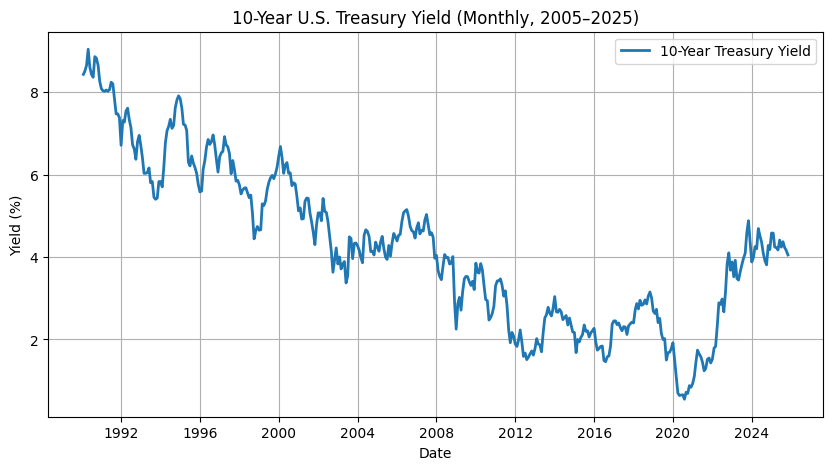

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, df_monthly['10Y_Yield'], label='10-Year Treasury Yield', linewidth=2)
plt.title('10-Year U.S. Treasury Yield (Monthly, 2005–2025)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()


Calibration period: 2005-01-31 → 2019-12-31
Holdout period: 2019-12-31 → 2025-09-30


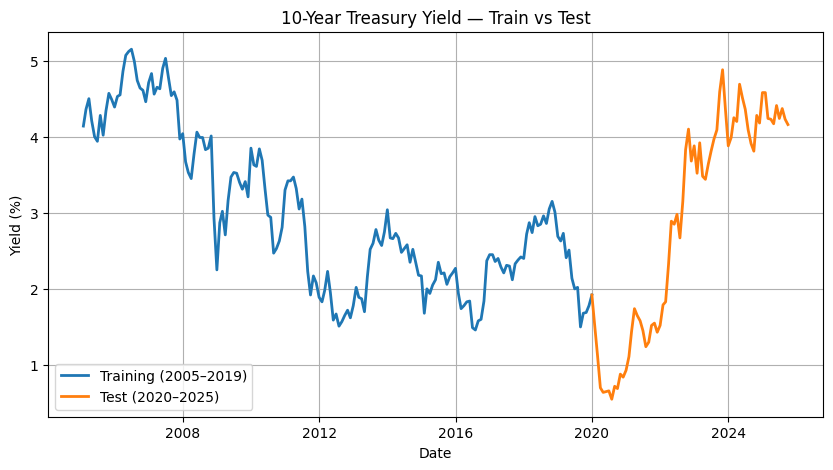

            10Y_Yield
Date                 
2005-01-31     0.0414
2005-02-28     0.0436
2005-03-31     0.0450
2005-04-30     0.0421
2005-05-31     0.0400
70


In [6]:
# Model Calibration
calibration = df_monthly.loc['2005-01-01':'2020-01-01'].copy()
calibration['10Y_Yield'] = calibration['10Y_Yield'] /100

# Holdout
holdout = df_monthly.loc['2019-12-01':'2025-10-15'].copy()
holdout['10Y_Yield'] = holdout['10Y_Yield'] /100

print("Calibration period:", calibration.index.min().date(), "→", calibration.index.max().date())
print("Holdout period:", holdout.index.min().date(), "→", holdout.index.max().date())

# Quick check: plot both
plt.figure(figsize=(10, 5))
plt.plot(calibration.index, calibration['10Y_Yield']*100, label='Training (2005–2019)', linewidth=2)
plt.plot(holdout.index, holdout['10Y_Yield']*100, label='Test (2020–2025)', linewidth=2)
plt.title('10-Year Treasury Yield — Train vs Test')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

print(calibration.head())

print(len(holdout))

In [7]:
# AD fuller test on calibration daTA


def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
adf_test(calibration)

def zatest(data):
    result = zivot_andrews(
        data,
        trim=0.1,
        maxlag=None,
        regression='ct',
        autolag='AIC')
    print('ZA Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[2])
zatest(calibration)

def kpsstest(data):
    result = kpss(data)
    print('KPSS Stat:', result[0])
    print('p-value:', result[1])
    print('crit-values:', result[3])
kpsstest(calibration)

ADF Statistic: -1.800205580857343
p-value: 0.3803596331946402
Critical Values: {'1%': np.float64(-3.4680615871598537), '5%': np.float64(-2.8781061899535128), '10%': np.float64(-2.5756015922004134)}
ZA Statistic: -4.8072386678529115
p-value: 0.10542629567575311
Critical Values: {'1%': np.float64(-5.57556), '5%': np.float64(-5.07332), '10%': np.float64(-4.82668)}
KPSS Stat: 1.3611852941677682
p-value: 0.01
crit-values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\ezras_rv8t6h7\AppData\Local\Temp\ipykernel_22696\3210308044.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data)


-0.0001240223463687151
ADF Statistic: -6.499764557977113
p-value: 1.169762006165189e-08
Critical Values: {'1%': np.float64(-3.4687256239864017), '5%': np.float64(-2.8783961376954363), '10%': np.float64(-2.57575634100705)}
ZA Statistic: -6.915141696233111
p-value: 0.0009849046512758627
Critical Values: {'1%': np.float64(-5.57556), '5%': np.float64(-5.07332), '10%': np.float64(-4.82668)}
KPSS Stat: 0.043232890712340724
p-value: 0.1
crit-values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\ezras_rv8t6h7\AppData\Local\Temp\ipykernel_22696\4159825816.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(data)


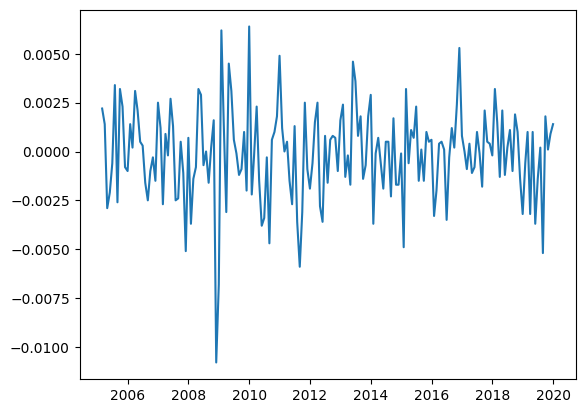

In [8]:
# AD fuller test on first difference of calibration daTA
c = calibration['10Y_Yield'].diff().dropna()

plt.plot(c)
print(c.mean())
def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
adf_test(c)

def zatest(data):
    result = zivot_andrews(
        data,
        trim=0.15,
        maxlag=None,
        regression='ct',
        autolag='AIC')
    print('ZA Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[2])
zatest(c)

def kpsstest(data):
    result = kpss(data)
    print('KPSS Stat:', result[0])
    print('p-value:', result[1])
    print('crit-values:', result[3])
kpsstest(c)

In [9]:
from arch.unitroot import VarianceRatio

# Example: suppose you have a DataFrame of Treasury yields
# df['10Y'] = your daily 10-year Treasury yields

# Compute yield changes (first difference)
# Run the variance ratio test
lags = [2,5,10,20]

for lag in lags:
    vr = VarianceRatio(c, lags=lag)
    print(vr.summary())

     Variance-Ratio Test Results     
Test Statistic                 -4.421
P-value                         0.000
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
     Variance-Ratio Test Results     
Test Statistic                 -3.640
P-value                         0.000
Lags                                5
-------------------------------------

Computed with overlapping blocks (de-biased)
     Variance-Ratio Test Results     
Test Statistic                 -2.987
P-value                         0.003
Lags                               10
-------------------------------------

Computed with overlapping blocks (de-biased)
     Variance-Ratio Test Results     
Test Statistic                 -2.292
P-value                         0.022
Lags                               20
-------------------------------------

Computed with overlapping blocks (de-biased)


In [33]:
# Calibration Paramters
dt = 1/12
rates = (calibration['10Y_Yield'].values) 

def logLikelihood(params):
    a, b , sigma = params

    if a <= 0 or sigma <= 0:
        return 1e10

    r_t = rates[:-1]
    r_t1 = rates[1:]

    # calcuate mean and variance from conditional expectation ad variance 
    mean = r_t +a*(b-r_t)*dt

    var = sigma**2*dt

    ll = -0.5*np.sum (np.log(2*np.pi*var) + ((r_t1 - mean)**2 / var))
    return -ll
    
b_init = np.mean(rates)
a_init = 0.1
sigma_init = np.std(np.diff(rates)) / np.sqrt(dt)

result = minimize(logLikelihood, 
                  x0=[a_init, b_init, sigma_init],
                  method='L-BFGS-B',
                  bounds=[(0.001, 5), (0, 100), (0.001, 100)])

a, b, sigma = result.x

print(f"Calibrated Parameters (MLE):")
print(f"  b: {b:.4%}")
print(f"  a: {a:.4f}")
print(f"  sigma: {sigma:.4f}")

Calibrated Parameters (MLE):
  b: 2.5275%
  a: 0.3452
  sigma: 0.0081


In [34]:
def vasicek(r0, a, b, dt, T, sigma, n_paths, clip_negative=False):
    n_steps = int(T/dt)
    r = np.zeros((n_paths,n_steps))
    r[:,0] = r0
    eps = np.random.randn(n_paths,n_steps - 1)
    for n in range(1,n_steps):
        dr = a*(b-r[:,n-1])*dt + sigma*np.sqrt(dt)*eps[:,n-1]
        r[:,n] = dr + r[:,n-1]
        
        if clip_negative:
            r[:, t] = np.clip(r[:, t], 0, None)
    return r

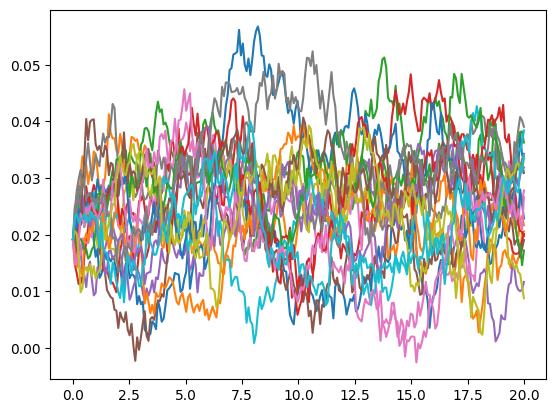

In [35]:
# 100 vasicek simulations into future

r0 = calibration['10Y_Yield'].iloc[-1]
time = np.linspace(0,20, 20*12)
simulation = vasicek(r0 = r0, a=a, b=b, sigma=sigma, dt = 1/12, T = 20, n_paths=1000)

plt.plot(time, simulation[:20].T)

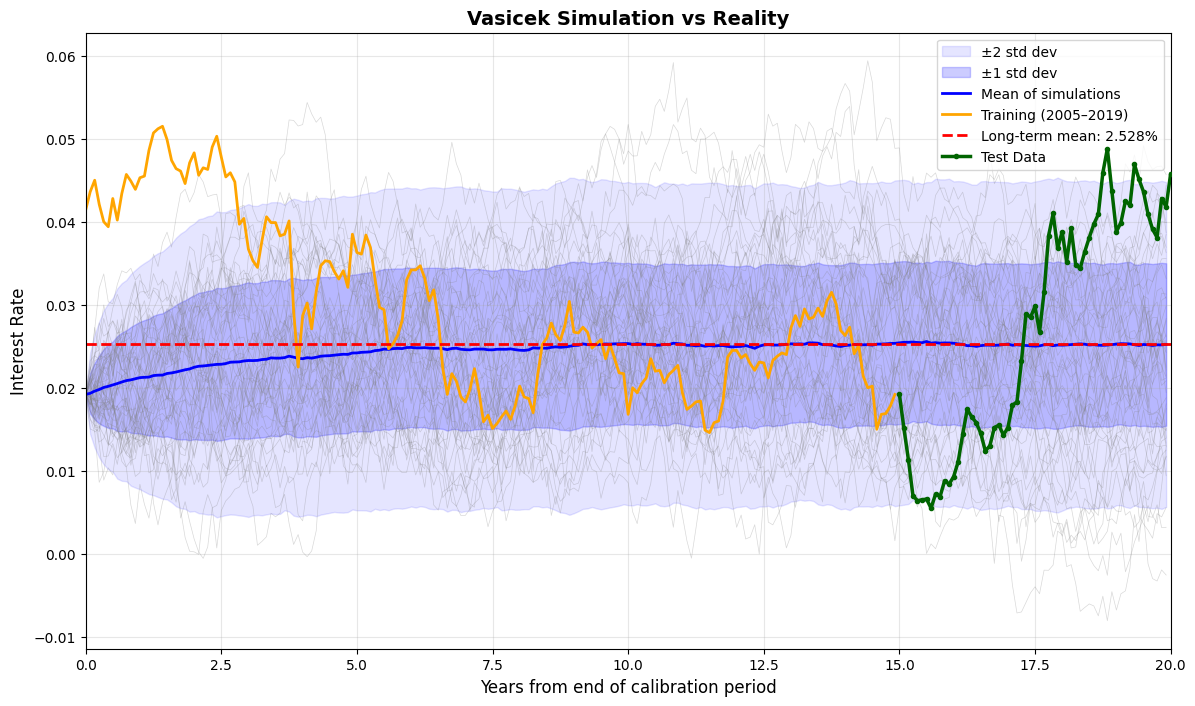

0.0192


In [36]:
# tim in years
time_years = np.arange(simulation.shape[1]) / 12

# randomly chose which paths to display
n_display = 50
random_paths = np.random.choice(1000, n_display, replace=False)

#Mean and standard deviation
mean_path = np.mean(simulation, axis=0)
std_path = np.std(simulation, axis=0)

# Confidence bands at 1 std
upper_band = mean_path + std_path
lower_band = mean_path - std_path

# confidence bands at 2 std
upper_band_2std = mean_path + 2 * std_path
lower_band_2std = mean_path - 2 * std_path

#Holdout Data
holdout_time = np.arange(len(holdout)) / 12 
holdout_rates = holdout['10Y_Yield'].values

#Figure
plt.figure(figsize=(14,8))
for idx in random_paths:
    plt.plot(time_years, simulation[idx, :], 
             color='gray', alpha=0.3, linewidth=0.5)
#confidence bands
plt.fill_between(time_years, lower_band_2std, upper_band_2std,
                 color='blue', alpha=0.1, label='±2 std dev')
plt.fill_between(time_years, lower_band, upper_band,
                 color='blue', alpha=0.2, label='±1 std dev')

# mean path
plt.plot(time_years, mean_path, 
         color='blue', linewidth=2, label='Mean of simulations')

calibration_time = np.arange(len(calibration)) / 12
plt.plot(calibration_time, calibration['10Y_Yield'], color='orange', 
         label='Training (2005–2019)', linewidth=2)

# historical mean
plt.axhline(b, color='red', linestyle='--', 
            linewidth=2, label=f'Long-term mean: {b:.3%}')
# historical data
plt.plot(holdout_time + len(calibration)/12, holdout_rates,
             color='darkgreen', linewidth=2.5, 
             label='Test Data', zorder=10,
             marker='o', markersize=3)


plt.xlabel('Years from end of calibration period', fontsize=12)
plt.ylabel('Interest Rate', fontsize=12)
plt.title('Vasicek Simulation vs Reality', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 20)

plt.show()
print(r0)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

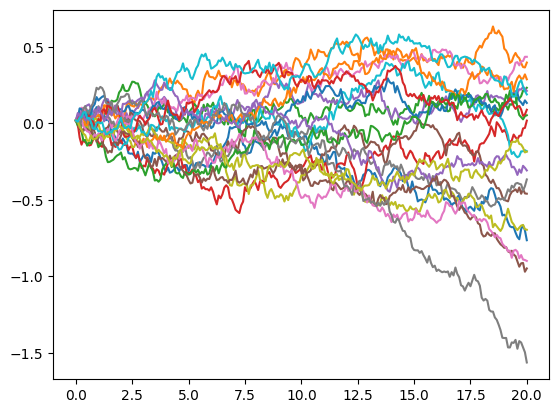

In [37]:
# Model 2: Random Walk
display(Latex(r'$dr_t = \sigma dW_t $'))
display(Latex(r'$dr_{t+1} = r_t + \sigma dW_t $'))
display(Latex(r'$ \sigma$: Volatility, $\hspace{5mm}$ $r_t:$ rates at time t, $\hspace{5mm}$ $W_t:$ Weiner process at time t '))

# Calculate modl parameters
# Initial rate
r0 = calibration['10Y_Yield'].iloc[-1]

# Volatility
monthly_changes = calibration['10Y_Yield'].diff().dropna()
monthly_std = monthly_changes.std()
sigma = monthly_std * np.sqrt(12)

# Random walk
def randomWalk(r0, sigma, T, dt, n_paths ):
    n_steps = int(T/dt)
    r = np.zeros((n_paths, n_steps + 1))
    r[:,0] = r0

    r[:,0] = r0
    for t in range(n_steps):
        dW = np.random.randn(n_paths) * np.sqrt(12)
        r[:,t+1] = r[:,t] + sigma * dW 
    return r

T = 20
dt = 1/12
n_paths = 1000

randomSimulation = randomWalk(r0, sigma, T, dt, n_paths)


times = np.linspace(0, T, int(T/dt) +1 )
plt.plot(times, randomSimulation[:20].T)

In [38]:
# Model 3: Cox-Ingersol-Ross(CIR)
display(Latex(r'$dr_t = v(\mu -r_t)dt + \sigma \sqrt{r_t} dW_t$'))
display(Latex(r'$r_t:$ rates at time t $\hspace{5mm}$ $v:$ speed of mean reversion $\hspace{5mm}$ $\mu:$ long term mean$\hspace{5mm}$ $\sigma:$ annualised volaitlity $\hspace{5mm}$ $W_t$: Weiner process at time t'))

def CIR(r0, v, mu, T, dt,sigma, n_paths) :
    n_steps = int(T/dt)
    r = np.zeros((n_paths, n_steps + 1))
    r[:,0] = r0
                 
    for t in range(n_steps):
        r_t = r[:,t]
        dW = np.random.randn(n_paths)*np.sqrt(dt)
        r[:,t+1] = r[:,t] + v*(mu - r_t)*dt + sigma*np.sqrt(r_t)*dW
        
    return r
    
# MLE of calibration parameters

# compute transition density
def transition_density(r_t, r_s, dt, sigma, v, mu):
    if r_t <= 0 or r_s <= 0 or dt <= 0:
        return 1e-10
    
    # Compute intermediate values
    exp_term = np.exp(-v * dt)
    c = 2*v / (sigma**2 * (1 - exp_term))
    q = 2 * v * mu / sigma**2 - 1
    u = r_s * exp_term * c
    nu = r_t * c
    
    # Check for numerical issues
    if c <= 0 or u <= 0 or nu <= 0:
        return 1e-10
    
    # Work in log space to avoid overflow
    log_c = np.log(c)
    log_ratio = (q/2) * (np.log(nu) - np.log(u))
    sqrt_term = 2 * np.sqrt(u * nu)
        
        # Modified Bessel function - use log version if available
    bessel_term = iv(q, sqrt_term)
        
        # Check if bessel is too large/small
    if bessel_term <= 0 or not np.isfinite(bessel_term):
        return 1e-10
        
    log_bessel = np.log(bessel_term)
        
        # Combine in log space
    log_density = log_c - u - nu + log_ratio + log_bessel
        
        # Convert back, capping extreme values
    if log_density > 20:  # e^20 ≈ 5e8, prevent overflow
        return 1e10
    elif log_density < -20:
        return 1e-10
        
    density = np.exp(log_density)
    return max(density, 1e-10)
        
            
def CIR_log_lik(params, data, dt):
    v, mu, sigma = params
    if v <= 0 or mu <= 0 or sigma <= 0:
        return np.inf
    ll = 0.0
    for i in range(1,len(data)):
        density = transition_density(data['10Y_Yield'].iloc[i], data['10Y_Yield'].iloc[i-1],dt, sigma, v, mu)
        ll += np.log(density)
    return - ll

def CIR_method_of_moments(data):
    """
    Estimate CIR parameters using method of moments
    """
    r = data['10Y_Yield'].values
    dt = 1/12  # Monthly data
    
    # Calculate moments
    mean_r = np.mean(r)
    var_r = np.var(r)
    
    # Calculate differences for autocorrelation
    dr = np.diff(r)
    
    # Autocorrelation at lag 1
    autocorr = np.corrcoef(r[:-1], r[1:])[0, 1]
    
    # Method of moments estimates
    # From CIR theory:
    # E[r] = mu (long-run mean)
    # Var[r] = (sigma^2 * mu) / (2*v)
    # Corr(r_t, r_{t+1}) = exp(-v*dt)
    
    mu = mean_r
    
    # From autocorrelation
    if autocorr > 0 and autocorr < 1:
        v = -np.log(autocorr) / dt
    else:
        v = 0.5  # fallback
    
    # From variance
    sigma = np.sqrt(2 * v * var_r / mu) if mu > 0 else 0.1
    
    print(f"Method of Moments Estimates:")
    print(f"  μ (long-run mean): {mu:.4f}")
    print(f"  v (mean reversion): {v:.4f}")
    print(f"  σ (volatility): {sigma:.4f}")
    print(f"\nFeller condition: 2vμ = {2*v*mu:.4f}, σ² = {sigma**2:.4f}")
    
    return v, mu, sigma


# Get initial guesses
v_init, mu_init, sigma_init = CIR_method_of_moments(calibration)

# Now optimize starting from these
result = minimize(CIR_log_lik, [v_init, mu_init, sigma_init], 
                  args=(calibration, 1/12),
                  method='L-BFGS-B', 
                  bounds=[(0.01, 5), (0.001, 0.1), (0.001, 0.5)],
                  options={'disp': True})

a, b, sigma = result.x

print(f"Calibrated Parameters (MLE):")
print(f"  b: {b:.4%}")
print(f"  a: {a:.4f}")
print(f"  sigma: {sigma:.4f}")

cirSim = CIR(r0, v,mu,20,1/12,sigma,1000)
time = np.linspace(1,20,241)

plt.plot(time, cirSim[:20].T)
print(np.mean(cirSim[-1]))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Method of Moments Estimates:
  μ (long-run mean): 0.0295
  v (mean reversion): 0.3388
  σ (volatility): 0.0481

Feller condition: 2vμ = 0.0200, σ² = 0.0023


C:\Users\ezras_rv8t6h7\AppData\Local\Temp\ipykernel_22696\571894966.py:119: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(CIR_log_lik, [v_init, mu_init, sigma_init],


Calibrated Parameters (MLE):
  b: 7.7676%
  a: 0.3198
  sigma: 0.0600


NameError: name 'v' is not defined

In [16]:
# Geometric Brownian Motion
display(Markdown("""
<div style="font-family: 'Times New Roman'; font-size: 15px;">
    <h1 style=""><b> Model x Geometric Brownian Motion:</b></h1>
"""))
display(Latex(r'$dr_t = \varphi dt + \nu dW_t$'))

def gbm (r0, phi, nu, T, dt, n_paths):
    n_steps = int(T/dt)
    r = np.zeros((n_paths, n_steps + 1))
    r[:,0] = r0

    for n in range(n_steps):
        dW = np.random.randn(n_paths)*np.sqrt(12)
        r[:, n+1] = r[:, n] + phi * dt + nu *dW
    return r
    
# Model calibration


<div style="font-family: 'Times New Roman'; font-size: 15px;">
    <h1 style=""><b> Model x Geometric Brownian Motion:</b></h1>


<IPython.core.display.Latex object>

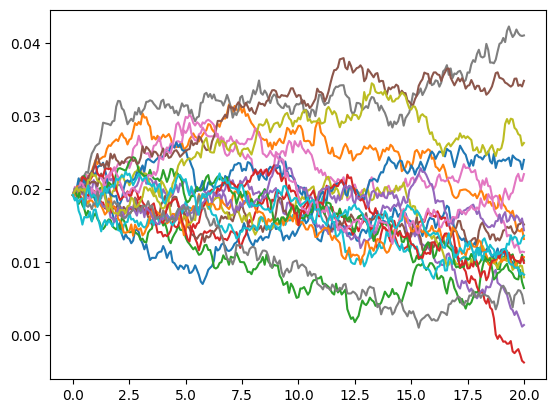

In [17]:
# Random walk with drift

def rwdrift(r0, phi, sigma, T, dt, n_paths):
    n_steps = int(T/dt)
    r = np.zeros((n_paths, n_steps + 1))
    r[:,0] = r0

    for n in range(n_steps):
        dW = np.random.randn(n_paths)*np.sqrt(dt)
        r[:, n+1] = r[:, n] + phi*dt  + nu *dW
    return r

# drift paramter
phi = c.mean()
nu = c.std()
r0 = calibration['10Y_Yield'].iloc[-1]

driftSim = rwdrift(r0, phi, nu, 20, 1/12, 1000) 
times = np.linspace(0, T, int(T/dt) +1 )
plt.plot(times, driftSim[:20].T)

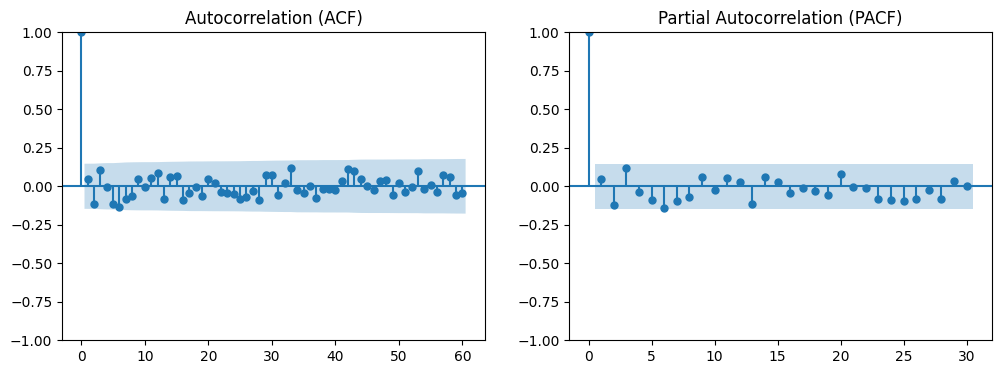

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(c, lags=60, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(c, lags=30, method='ywm', ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.show()

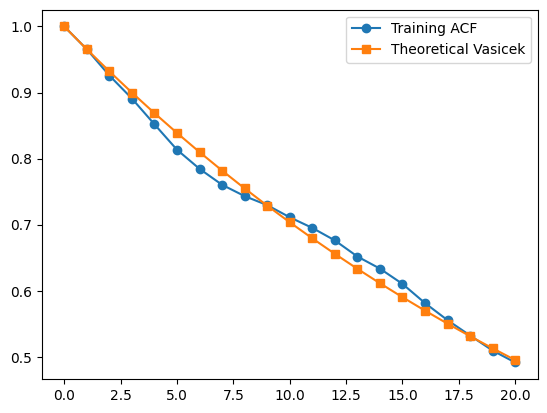

In [19]:
# Sample ACF
sample_acf = acf(calibration, nlags=20)

# Estimate kappa (simplified - use MLE for better results)
# From AR(1) approximation: kappa ≈ -log(ρ(1))/Δt
kappa_est = -np.log(sample_acf[1]) / dt

# Theoretical ACF
lags = np.arange(21)
theoretical_acf = np.exp(-kappa_est * lags * dt)

# Plot comparison
plt.plot(lags, sample_acf, 'o-', label='Training ACF')
plt.plot(lags, theoretical_acf, 's-', label='Theoretical Vasicek')
plt.legend(loc='best')

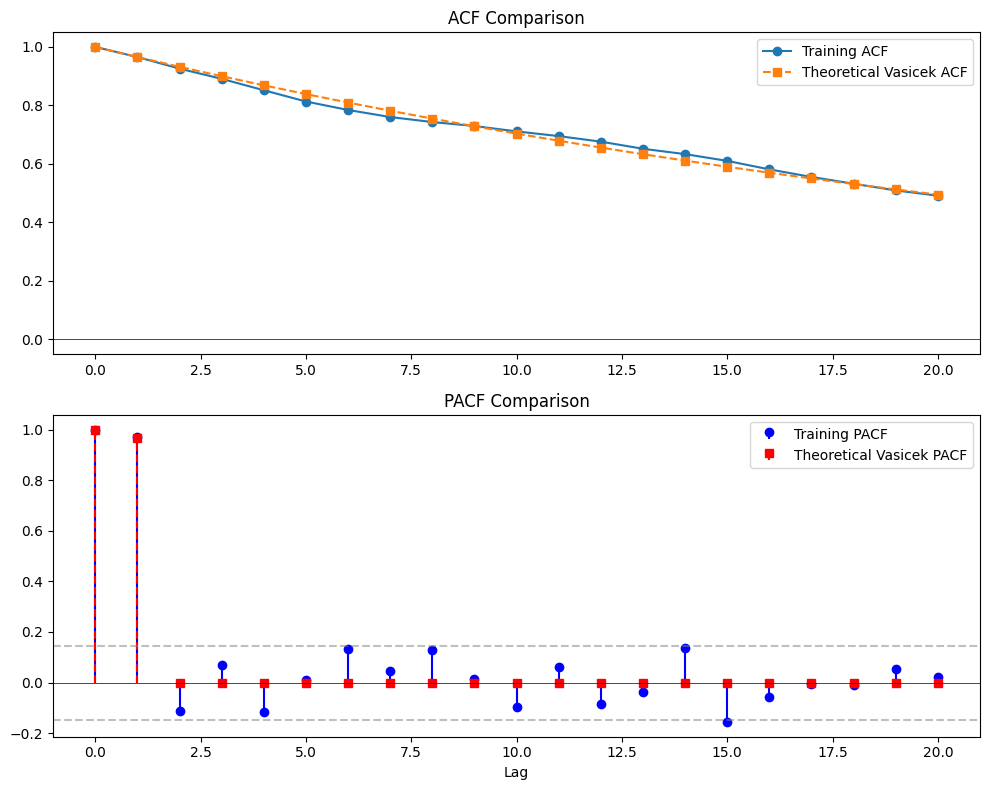

In [20]:
sample_acf = acf(calibration, nlags=20)
dt = 1  # your time step
kappa_est = -np.log(sample_acf[1]) / dt

# Calculate both ACF and PACF
sample_pacf = pacf(calibration, nlags=20)

# Theoretical values
lags = np.arange(21)
theoretical_acf = np.exp(-kappa_est * lags * dt)
theoretical_pacf = np.zeros(21)
theoretical_pacf[0] = 1
theoretical_pacf[1] = np.exp(-kappa_est * dt)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF comparison
ax1.plot(lags, sample_acf, 'o-', label='Training ACF')
ax1.plot(lags, theoretical_acf, 's--', label='Theoretical Vasicek ACF')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.legend()
ax1.set_title('ACF Comparison')

# PACF comparison
conf = 1.96 / np.sqrt(len(calibration))
ax2.stem(lags, sample_pacf, linefmt='b-', markerfmt='bo', 
         basefmt=' ', label='Training PACF')
ax2.stem(lags, theoretical_pacf, linefmt='r--', markerfmt='rs',
         basefmt=' ', label='Theoretical Vasicek PACF')
ax2.axhline(conf, linestyle='--', color='gray', alpha=0.5)
ax2.axhline(-conf, linestyle='--', color='gray', alpha=0.5)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.legend()
ax2.set_title('PACF Comparison')
ax2.set_xlabel('Lag')

plt.tight_layout()
plt.show()

In [ ]:
base_params = {
    'a': 0.35,
    'b': 0.0253,
    'sigma': 0.0081,
}

# Simulation settings
dt = 1/12
T = 30
n_paths = 10000
year_10_idx = int(10 / dt)

# Calculate base case
np.random.seed(42)
base_scenarios = vasicek(**base_params, r0=r0, dt=dt, T=T, n_paths=n_paths)
rates_year10_base = base_scenarios[:, year_10_idx]

base_metrics = {
    'p5': np.percentile(rates_year10_base, 5),
    'p95': np.percentile(rates_year10_base, 95),
    'prob_neg': np.mean(rates_year10_base < 0) * 100,
    'p1': np.percentile(rates_year10_base, 1),
    'p99': np.percentile(rates_year10_base, 99),
}

# Define sensitivity ranges
sensitivity_params = {
    'κ (mean reversion)': {
        'param_name': 'a',
        'low': 0.175,
        'high': 0.525,
        'base': 0.35
    },
    'θ (long-term mean)': {
        'param_name': 'b',
        'low': 0.02,
        'high': 0.03,
        'base': 0.0253
    },
    'σ (volatility)': {
        'param_name': 'sigma',
        'low': 0.005,
        'high': 0.012,
        'base': 0.0081
    },
}

# Choose metric for tornado chart
# Options: 'p5', 'p95', 'prob_neg', 'p1', 'p99'
METRIC = 'p5'  # 5th percentile (downside tail risk)

metric_labels = {
    'p5': '5th Percentile Rate',
    'p95': '95th Percentile Rate',
    'prob_neg': 'Probability of Negative Rates',
    'p1': '1st Percentile Rate',
    'p99': '99th Percentile Rate',
}

# Calculate impacts for each parameter
results = {}
for param_label, config in sensitivity_params.items():
    param_name = config['param_name']
    
    # Low scenario
    params_low = base_params.copy()
    params_low[param_name] = config['low']
    np.random.seed(42)
    scenarios_low = vasicek(**params_low, r0=r0, dt=dt, T=T, n_paths=n_paths)
    rates_low = scenarios_low[:, year_10_idx]
    
    # High scenario
    params_high = base_params.copy()
    params_high[param_name] = config['high']
    np.random.seed(42)
    scenarios_high = vasicek(**params_high, r0=r0, dt=dt, T=T, n_paths=n_paths)
    rates_high = scenarios_high[:, year_10_idx]
    
    # Calculate metrics
    if METRIC == 'prob_neg':
        metric_low = np.mean(rates_low < 0) * 100
        metric_high = np.mean(rates_high < 0) * 100
        metric_base = base_metrics[METRIC]
        multiplier = 1  # Already in percentage points
    elif METRIC in ['p5', 'p95', 'p1', 'p99']:
        percentile = int(METRIC[1:])
        metric_low = np.percentile(rates_low, percentile)
        metric_high = np.percentile(rates_high, percentile)
        metric_base = base_metrics[METRIC]
        multiplier = 100  # Convert to basis points
    
    # Store results
    results[param_label] = {
        'low_impact': (metric_low - metric_base) * multiplier,
        'high_impact': (metric_high - metric_base) * multiplier,
        'range': abs(metric_high - metric_low) * multiplier,
        'low_val': config['low'],
        'high_val': config['high'],
        'base_val': config['base']
    }

# Sort by range (largest tail risk impact first)
sorted_results = sorted(results.items(), key=lambda x: x[1]['range'], reverse=True)

# Prepare plotting data
param_names = [r[0] for r in sorted_results]
low_impacts = [r[1]['low_impact'] for r in sorted_results]
high_impacts = [r[1]['high_impact'] for r in sorted_results]

# Create labels
labels_with_values = []
for name, data in sorted_results:
    labels_with_values.append(
        f"{name}\n[{data['low_val']:.4f} | {data['base_val']:.4f} | {data['high_val']:.4f}]"
    )

# Create tornado chart
fig, ax = plt.subplots(figsize=(13, 7))

y_pos = np.arange(len(param_names))

# Plot bars
bars_low = ax.barh(y_pos, low_impacts, height=0.7, 
                   color='#d62728', alpha=0.8, label='Low Parameter Value')
bars_high = ax.barh(y_pos, high_impacts, height=0.7, 
                    color='#2ca02c', alpha=0.8, label='High Parameter Value')

# Determine units
if METRIC == 'prob_neg':
    units = 'percentage points'
    base_value_str = f"{base_metrics[METRIC]:.2f}%"
else:
    units = 'basis points'
    base_value_str = f"{base_metrics[METRIC]*100:.2f}%"

# Customize chart
ax.set_yticks(y_pos)
ax.set_yticklabels(labels_with_values, fontsize=10)
ax.set_xlabel(f'Impact on {metric_labels[METRIC]} ({units})', fontsize=11)
ax.set_title(
    f'Vasicek Tail Risk Sensitivity Analysis - {metric_labels[METRIC]}\n'
    f'Base Case: {base_value_str} | Year 10 | Paths: {n_paths:,}',
    fontsize=13, fontweight='bold', pad=20
)
ax.axvline(x=0, color='black', linewidth=1.2, linestyle='-')
ax.legend(loc='best', fontsize=10)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (low, high) in enumerate(zip(low_impacts, high_impacts)):
    if abs(low) > 0.5:
        if METRIC == 'prob_neg':
            label = f'{low:.1f}pp'
        else:
            label = f'{low:.1f}bp'
        ax.text(low - (max(abs(min(low_impacts)), abs(max(high_impacts))) * 0.02), i, label,
               va='center', ha='right', fontsize=9, fontweight='bold')
    if abs(high) > 0.5:
        if METRIC == 'prob_neg':
            label = f'{high:.1f}pp'
        else:
            label = f'{high:.1f}bp'
        ax.text(high + (max(abs(min(low_impacts)), abs(max(high_impacts))) * 0.02), i, label,
               va='center', ha='left', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary for all tail metrics
print(f"\nVasicek Tail Risk Sensitivity Analysis (Year 10)")
print(f"Base Case Metrics:")
print(f"  5th Percentile:  {base_metrics['p5']*100:.4f}%")
print(f"  95th Percentile: {base_metrics['p95']*100:.4f}%")
print(f"  Prob(r < 0):     {base_metrics['prob_neg']:.2f}%")
print(f"\nCurrent Chart Metric: {metric_labels[METRIC]}")
print("-" * 90)
print(f"{'Parameter':<25} {'Range':<15} {'Low Impact':<18} {'High Impact':<18}")
print("-" * 90)
for param, data in sorted_results:
    unit = 'pp' if METRIC == 'prob_neg' else 'bp'
    print(f"{param:<25} {data['range']:>10.2f} {unit}   "
          f"{data['low_impact']:>13.2f} {unit}   "
          f"{data['high_impact']:>13.2f} {unit}")

print(f"\nNote: Change METRIC variable to analyze different tail risks:")
print(f"  'p5' = 5th percentile (downside risk)")
print(f"  'p95' = 95th percentile (upside scenarios)")  
print(f"  'prob_neg' = Probability of negative rates")

In [ ]:
print("TEST 1: MEAN/VARIANCE MATCH")
print("=" * 60)

# historical statistics from calibration 
hist_mean = np.mean(calibration['10Y_Yield'])
hist_var = np.var(calibration['10Y_Yield'])
hist_std = np.std(calibration['10Y_Yield'])

print(f"\nHistorical Statistics (calibration period):")
print(f"  Mean:     {hist_mean:.4%}")
print(f"  Variance: {hist_var:.6%}")
print(f"  Std Dev:  {hist_std:.4%}")

horizons = [1,2,5,10,239/12]
results = []

# calculate simulatio stats
for year in horizons:
    month_idx = int(year*12)
    
    rates_at_horizon = simulation[:, month_idx]

    sim_mean = np.mean(rates_at_horizon)
    sim_var = np.var(rates_at_horizon)
    sim_std = np.std(rates_at_horizon)

    # percentage difference from historical
    mean_diff_pct = abs(sim_mean - hist_mean) / hist_mean * 100
    var_diff_pct = abs(sim_var - hist_var) / hist_var * 100

    results.append({
        'year': year,
        'sim_mean': sim_mean,
        'sim_var': sim_var,
        'sim_std': sim_std,
        'mean_diff_pct': mean_diff_pct,
        'var_diff_pct': var_diff_pct
    })
    print(f"\nYear {int(np.ceil(year))}:")
    print(f"  Simulated Mean:     {sim_mean:.4f} (diff: {mean_diff_pct:.1f}%)")
    print(f"  Simulated Variance: {sim_var:.6f} (diff: {var_diff_pct:.1f}%)")
    print(f"  Simulated Std Dev:  {sim_std:.4f}")
    
# thresholds
MEAN_THRESHOLD = 20  # within 20% is acceptable
VAR_THRESHOLD = 30   # within 30% is acceptable (variance is noisier)

print("\n" + "=" * 60)

print("PASS/FAIL ASSESSMENT")
print("=" * 60)
final_result = results[-1]  # Year 20

# Check if simulation passs
mean_pass = final_result['mean_diff_pct'] < MEAN_THRESHOLD
var_pass = final_result['var_diff_pct'] < VAR_THRESHOLD
overall_pass = mean_pass and var_pass

print(f"\nCriteria (at Year 20):")
print(f"  Mean within {MEAN_THRESHOLD}%:     {'PASS' if mean_pass else 'FAIL'} "
      f"(actual: {final_result['mean_diff_pct']:.1f}%)")
print(f"  Variance within {VAR_THRESHOLD}%:  {'PASS' if var_pass else 'FAIL'} "
      f"(actual: {final_result['var_diff_pct']:.1f}%)")

print(f"\n{'='*60}")
print(f"TEST 1 OVERALL: {'✓ PASS' if overall_pass else '✗ FAIL'}")
print(f"{'='*60}")
summary_df = pd.DataFrame(results)
summary_df['mean_pass'] = summary_df['mean_diff_pct'] < MEAN_THRESHOLD
summary_df['var_pass'] = summary_df['var_diff_pct'] < VAR_THRESHOLD

#SUBPLOTS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot 1: Mean convergence
ax1 = axes[0]
years = [r['year'] for r in results]
sim_means = [r['sim_mean'] for r in results]

ax1.plot(years, sim_means, 'o-', linewidth=2, markersize=8, 
         label='Simulated Mean', color='blue')
ax1.axhline(hist_mean, color='red', linestyle='--', linewidth=2, 
            label=f'Historical Mean ({hist_mean:.4f})')
ax1.axhline(b, color='green', linestyle=':', linewidth=2,
            label=f'Model reverting mean ({b:.4f})')

# Add acceptable band
ax1.fill_between(years, 
                 hist_mean * (1 - MEAN_THRESHOLD/100),
                 hist_mean * (1 + MEAN_THRESHOLD/100),
                 alpha=0.2, color='gray', label=f'±{MEAN_THRESHOLD}% band')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Mean Rate', fontsize=12)
ax1.set_title('Mean Convergence Over Time', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Variance comparison
ax2 = axes[1]
sim_vars = [r['sim_var'] for r in results]

ax2.plot(years, sim_vars, 's-', linewidth=2, markersize=8,
         label='Simulated Variance', color='blue')
ax2.axhline(hist_var, color='red', linestyle='--', linewidth=2,
            label=f'Historical Variance ({hist_var:.6f})')

# Add acceptable band
ax2.fill_between(years,
                 hist_var * (1 - VAR_THRESHOLD/100),
                 hist_var * (1 + VAR_THRESHOLD/100),
                 alpha=0.2, color='gray', label=f'±{VAR_THRESHOLD}% band')

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Variance', fontsize=12)
ax2.set_title('Variance Over Time', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Test 2: Kolmogorv-Smirnov test

def KS_test(calibration, holdout, simulation_data, model_name):
    # Test on calibration data
    calibration_changes = calibration['10Y_Yield'].diff().dropna().values
    sim_changes = np.diff(simulation_data, axis=1).flatten()
    
    ks_calibration, p_calibration = stats.ks_2samp(calibration_changes, sim_changes)

    #  Test on holdout
    holdout_changes = holdout['10Y_Yield'].diff().dropna().values
    ks_holdout, p_holdout = stats.ks_2samp(holdout_changes, sim_changes)
    
    # Dict of results
    results = {
        'model': model_name,
        'train_ks': ks_calibration,
        'train_p': f'{p_calibration:.2f}',
        'train_pass': p_calibration > 0.05,
        'holdout_ks': ks_holdout,
        'holdout_p': f'{p_holdout:.2f}',
        'holdout_pass': p_holdout > 0.05,
        'generalization': 'Good' if (p_calibration > 0.05 and p_holdout > 0.05) else 'Poor'
    }
    
    return results
GBM_results = KS_test(calibration, holdout, driftSim, ' Geometric Brownian Motion')
V_results = KS_test(calibration, holdout, simulation, 'Vasicek')

comparison = pd.DataFrame([V_results, GBM_results], )

print("\nModel Validation Results:")
print(comparison[['model', 'train_ks','train_p', 'train_pass' ,'holdout_ks','holdout_p', 'holdout_pass', 'generalization']])


In [ ]:
# QQ Plot

def plot_qq_comparison(simulated_paths, historical_data, model_name, data_name):
    """
    Q-Q plot to visualize distribution comparison
    """
    # Get changes
    hist_changes = historical_data.diff().dropna().values
    sim_changes = np.diff(simulated_paths, axis=1).flatten()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Q-Q plot
    from scipy import stats
    
    # Sort both for Q-Q plot
    hist_sorted = np.sort(hist_changes)
    sim_sorted = np.sort(sim_changes)
    
    # Sample quantiles (match sizes)
    n = min(len(hist_sorted), len(sim_sorted))
    quantiles = np.linspace(0, 1, n)
    hist_quantiles = np.quantile(hist_sorted, quantiles)
    sim_quantiles = np.quantile(sim_sorted, quantiles)
    
    # Q-Q plot
    axes[0].scatter(hist_quantiles, sim_quantiles, alpha=0.5, s=10)
    axes[0].plot([hist_quantiles.min(), hist_quantiles.max()], 
                 [hist_quantiles.min(), hist_quantiles.max()], 
                 'r--', lw=2, label='Perfect fit')
    axes[0].set_xlabel(f'{data_name} Quantiles')
    axes[0].set_ylabel(f'{model_name} Quantiles')
    axes[0].set_title(f'Q-Q Plot: {model_name} vs {data_name}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Histogram comparison
    axes[1].hist(hist_changes, bins=50, alpha=0.5, label=f'{data_name}', density=True)
    axes[1].hist(sim_changes, bins=50, alpha=0.5, label=model_name, density=True)
    axes[1].set_xlabel('Rate Changes')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Distribution Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_qq_comparison(simulation, holdout, 'Vasicek', ' Holdout Data')
plot_qq_comparison(simulation,calibration, 'Vasicek', ' Calibration')

plot_qq_comparison(driftSim, holdout, 'GBM', ' Holdout Data')
plot_qq_comparison(driftSim,calibration, 'GBM', ' Calibration')


In [ ]:
display(Markdown("""
Floor Analysis
"""))
def floor_analysis(sims, test_data, model_name):
    # Find Minimums and mimimum quantiles
    test_min = float(test_data.min())
    sim_min = sims.min()
    sim_5th_percentile = np.percentile(sims, 5)
    
    # simulation Quantiles below 0 and historic min 
    pct_below_test_min = (sims < test_min).sum() / sims.size * 100
    pct_negative = (sims < 0).sum() / sims.size * 100
        
    results = {
        'model': model_name,
        'test_min': test_min,
        'sim_min': sim_min,
        'sim_5th_percentile': sim_5th_percentile,
        'pct_below_hist_min': pct_below_test_min,
        'pct_negative': pct_negative,
        'interpretation': interpret_floor(test_min, sim_min, pct_negative)
    }
    print(f"\n{'='*60}")
    print(f"Rate Floor Analysis: {model_name}")
    print(f"{'='*60}")
    print(f"Historical minimum rate:     {test_min:>8.4f}")
    print(f"Simulated minimum rate:      {sim_min:>8.4f}")
    print(f"Simulated 5th percentile:    {sim_5th_percentile:>8.4f}")
    print(f"-" * 60)
    print(f"% below test minimum:  {pct_below_test_min:>7.2f}%")
    print(f"% negative rates:            {pct_negative:>7.2f}%")
    print(f"-" * 60)
    print(f"{results['interpretation']}")
    print(f"{'='*60}\n")
    return results
    
def interpret_floor(hist_min, sim_min, pct_negative):
    if hist_min >= 0 and pct_negative > 5:
        return " Model generates negative rates not seen historically"
    elif hist_min < 0 and pct_negative < 1:
        return " Model may underestimate negative rate risk"
    else:
        return " Model's rate floor behavior is consistent with history"
floor = floor_analysis(simulation, calibration, 'vasicek') 
print(floor['interpretation'])
    

In [ ]:
def acf_test(sims, test, nlags = 24, model_name='model_nae'):
    #hisorical acf
    test_changes = test['10Y_Yield'].diff().dropna().values
    #acf and pacf
    test_acf = acf(test_changes, nlags=nlags, fft=False)
    test_pacf = pacf(test_changes, nlags=nlags)

    # average simulation acf:
    sim_acf = []
    for i in range(min(100, sims.shape[0])):  
        path_changes = np.diff(sims[i, :len(test)])
        if len(path_changes) >= nlags + 1:
            sim_acf.append(acf(path_changes, nlags=nlags, fft=False))
    
    sim_acf_avg = np.mean(sim_acf, axis=0)

    # average simulation pacf
    sim_pacf = []
    for i in range(min(100, sims.shape[0])):  
        path_changes = np.diff(sims[i, :len(test)])
        if len(path_changes) >= nlags + 1:
            sim_pacf.append(pacf(path_changes, nlags=nlags))
    
    sim_pacf_avg = np.mean(sim_pacf, axis=0)

    # Maximum distances
    acf_max_diff = np.max(np.abs(test_acf - sim_acf_avg))
    pacf_max_diff = np.max(np.abs(test_pacf - sim_pacf_avg))

    # mean squared eror
    acf_rmse = np.sqrt(np.mean((test_acf - sim_acf_avg)**2))
    pacf_rmse = np.sqrt(np.mean((test_pacf - sim_pacf_avg)**2))

    acf_pass_test = acf_max_diff < 0.2
    pacf_pass_test = pacf_max_diff < 0.2
    
    results = {
        'model': model_name,
        'test': 'Autocorrelation & Partial Autocorrelation',
        'acf_max_diff': acf_max_diff,
        'pacf_max_diff': pacf_max_diff,
        'acf_rmse': acf_rmse,
        'pacf_rmse': pacf_rmse,
        'acf_pass': acf_pass_test,
        'pacf_pass': pacf_pass_test,
        'test_acf': test_acf,
        'test_pacf': test_pacf,
        'sim_acf': sim_acf_avg,
        'sim_pacf': sim_pacf_avg,
        'threshold': 0.2,
        'acf_interpretation': f"{'✓ ACF PASS' if acf_pass_test else '✗ FAIL'} - ACF structure {'matches' if acf_pass_test else 'differs from'} historical",
        'pacf_interpretation': f"{'✓ PACF PASS' if pacf_pass_test else '✗ FAIL'} - PACF structure {'matches' if pacf_pass_test else 'differs from'} historical"
    }
    
    return results
def plot_acf_comparison(acf_results, confidence_level=0.05):
    """
    Plot ACF comparison between historical and simulated
    """
    test_acf = acf_results['test_acf']
    sim_acf = acf_results['sim_acf']
    model_name = acf_results['model']
    nlags = len(test_acf) - 1
    
    # Confidence bands (approximate)
    n_obs = 100  # Approximate, adjust based on your data
    conf_int = 1.96 / np.sqrt(n_obs)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    lags = np.arange(nlags + 1)
    
    # Plot historical ACF
    ax.stem(lags, test_acf, linefmt='C0-', markerfmt='C0o', 
            basefmt=' ', label='Historical')
    
    # Plot simulated ACF
    ax.stem(lags + 0.2, sim_acf, linefmt='C1-', markerfmt='C1s', 
            basefmt=' ', label=model_name)
    
    # Confidence bands
    ax.axhline(y=conf_int, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=-conf_int, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    ax.set_xlabel('Lag (months)')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'Autocorrelation Comparison: {model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add text box with results
    textstr = f"Max Diff: {acf_results['acf_max_diff']:.4f}\nRMSE: {acf_results['acf_rmse']:.4f}\n{acf_results['acf_interpretation']}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()

def plot_pacf_comparison(pacf_results, confidence_level=0.05):
    """
    Plot PACF comparison between historical and simulated
    """
    test_pacf = pacf_results['test_pacf']
    sim_pacf = pacf_results['sim_pacf']
    model_name = pacf_results['model']
    nlags = len(test_pacf) - 1
    
    # Confidence bands (approximate)
    n_obs = 100  # Approximate, adjust based on your data
    conf_int = 1.96 / np.sqrt(n_obs)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    lags = np.arange(nlags + 1)
    
    # Plot testorical pacf
    ax.stem(lags, test_pacf, linefmt='C0-', markerfmt='C0o', 
            basefmt=' ', label='Historical')
    
    # Plot simulated pacf
    ax.stem(lags + 0.2, sim_pacf, linefmt='C1-', markerfmt='C1s', 
            basefmt=' ', label=model_name)
    
    # Confidence bands
    ax.axhline(y=conf_int, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=-conf_int, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    ax.set_xlabel('Lag (months)')
    ax.set_ylabel(' partial-Autocorrelation')
    ax.set_title(f'Partial-Autocorrelation Comparison: {model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add text box with results
    textstr = f"Max Diff: {pacf_results['pacf_max_diff']:.4f}\nRMSE: {pacf_results['pacf_rmse']:.4f}\n{pacf_results['pacf_interpretation']}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()

results = acf_test(simulation, calibration, model_name='vasicek')
plot_acf_comparison(results)
plot_pacf_comparison(results)

In [ ]:
plot_pacf(calibration, lags=48, method='ywm', ax=axes[1])

In [ ]:
def tail_behaviour(sim, test_data, model_name):
    hist_changes = test_data['10Y_Yield'].diff().dropna().values
    sim_changes = np.diff(sim, axis=1).flatten()
    
    # Define tail percentiles
    lower_percentiles = [1, 5, 10]
    upper_percentiles = [90, 95, 99]
    
    # Calculate percentiles
    hist_lower = [np.percentile(hist_changes, p) for p in lower_percentiles]
    hist_upper = [np.percentile(hist_changes, p) for p in upper_percentiles]
    
    sim_lower = [np.percentile(sim_changes, p) for p in lower_percentiles]
    sim_upper = [np.percentile(sim_changes, p) for p in upper_percentiles]
    
    # Calculate differences (how far off are the tails?)
    lower_diffs = [abs(s - h) for s, h in zip(sim_lower, hist_lower)]
    upper_diffs = [abs(s - h) for s, h in zip(sim_upper, hist_upper)]
    
    # Maximum difference across all percentiles
    max_lower_diff = max(lower_diffs)
    max_upper_diff = max(upper_diffs)
    max_diff = max(max_lower_diff, max_upper_diff)
    
    # Relative differences (as % of historical value)
    lower_rel_diffs = [abs(s - h) / abs(h) * 100 if h != 0 else 0 
                       for s, h in zip(sim_lower, hist_lower)]
    upper_rel_diffs = [abs(s - h) / abs(h) * 100 if h != 0 else 0 
                       for s, h in zip(sim_upper, hist_upper)]
    
    # Pass criteria: Max difference < 0.01 (1% in absolute terms)
    # OR relative difference < 30% of historical tail value
    pass_absolute = max_diff < 0.01
    pass_relative = max(lower_rel_diffs + upper_rel_diffs) < 30
    
    pass_test = pass_absolute or pass_relative
    
    results = {
        'model': model_name,
        'test': 'Tail Behavior',
        'hist_lower_tail': hist_lower,
        'sim_lower_tail': sim_lower,
        'hist_upper_tail': hist_upper,
        'sim_upper_tail': sim_upper,
        'lower_diffs': lower_diffs,
        'upper_diffs': upper_diffs,
        'max_diff': max_diff,
        'max_rel_diff': max(lower_rel_diffs + upper_rel_diffs),
        'pass': pass_test,
        'interpretation': interpret_tails(max_diff, max(lower_rel_diffs + upper_rel_diffs), pass_test)
    }
    
    return results


def interpret_tails(max_diff, max_rel_diff, passed):
    """
    Interpret tail behavior results
    """
    if passed:
        return f"✓ PASS - Tail behavior matches (max diff: {max_diff:.4f})"
    else:
        return f"✗ FAIL - Tails differ significantly (max diff: {max_diff:.4f}, {max_rel_diff:.1f}%)"
        
vasicek_tail = tail_behaviour(simulation, calibration, 'Vasicek')

print(vasicek_tail['interpretation'])


def tail_moments(sim, test_data, model_name):
    hist_changes = test_data['10Y_Yield'].diff().dropna().values
    sim_changes = np.diff(sim, axis=1).flatten()

    # skew
    hist_skew = stats.skew(hist_changes)
    sim_skew = stats.skew(sim_changes)

    # kurtosis
    hist_kurt = stats.kurtosis(hist_changes, fisher=True)  
    sim_kurt = stats.kurtosis(sim_changes, fisher=True)

    skew_diff = abs(sim_skew - hist_skew)
    kurt_diff = abs(sim_kurt - hist_kurt)
    
    # Pass criteria
    pass_skew = skew_diff < 0.5
    pass_kurt = kurt_diff < 1.0
    pass_test = pass_skew and pass_kurt
    
    results = {
        'model': model_name,
        'test': 'Tail Moments',
        'hist_skewness': hist_skew,
        'sim_skewness': sim_skew,
        'hist_kurtosis': hist_kurt,
        'sim_kurtosis': sim_kurt,
        'skew_diff': skew_diff,
        'kurt_diff': kurt_diff,
        'pass': pass_test,
        'interpretation': f"{'PASS' if pass_test else 'FAIL'} - Skew diff: {skew_diff:.3f}, Kurt diff: {kurt_diff:.3f}"
    }
    
    return results

vasicek_moments = tail_moments(simulation, holdout, 'Vasicek')
print("\nTail Behavior Test Results:")
print(f"{'Model':<15} {'Max Diff':<12} {'Max Rel %':<12} {'Result'}")
print("-" * 65)
print(f"{'Vasicek':<15} {vasicek_tail['max_diff']:<12.4f} {vasicek_tail['max_rel_diff']:<12.1f} {vasicek_tail['interpretation']}")


print("\n\nHigher Moments Test Results:")
print(f"{'Model':<15} {'Skew (H/S)':<20} {'Kurt (H/S)':<20} {'Result'}")
print("-" * 75)
print(f"{'Vasicek':<15} {vasicek_moments['hist_skewness']:>6.3f} / {vasicek_moments['sim_skewness']:<6.3f}   {vasicek_moments['hist_kurtosis']:>6.3f} / {vasicek_moments['sim_kurtosis']:<6.3f}   {vasicek_moments['interpretation']}")


    

In [43]:
# Pending Funding Ratio analysis:

def funding_ratio(kappa=0.34, theta=0.025, sigma=0.008, assets_0=100, liabilities_0=100, liability_dur=12, projection_years=10, liability_convexity=150, model_name='model_name' ):
   
    sim = vasicek(r0 = 0.0192,a= kappa, b= theta, sigma=sigma, dt=1/12, T=20, n_paths=1000)
    
    n_paths, n_steps = sim.shape
    dt = 1/12
    steps_per_year = int(1/dt)
    projection_steps = min(projection_years * steps_per_year, n_steps)

    
    # initial rate;
    r0 = sim[:,0].mean()

    # funding ratios
    funding_ratios = np.zeros(n_paths)
    funding_ratios_over_time = np.zeros((n_paths, projection_steps))

    for i in range(n_paths):
        assets = assets_0
        liabilities = liabilities_0

        for t in range(projection_steps):
            rate = sim[i,t]

            # asset growth rate
            if t>0:
                assets *= (1 +rate*dt)

            if t>0:
                rate_change = rate - sim[i,t-1]

                duration_effect = -liability_dur * rate_change
                convexity_effect = 0.5*liability_convexity*(rate_change**2)
                liabilities *= (1+ duration_effect + convexity_effect) 
                
            # fund ratios
            funding_ratios_over_time[i, t] = assets / liabilities
            
        funding_ratios[i] = funding_ratios_over_time[i, -1]

        results = {
        'model': model_name,
        'funding_ratios': funding_ratios,
        'pct_underfunded': (funding_ratios < 1.0).sum() / n_paths * 100,
        'pct_severely_underfunded': (funding_ratios < 0.8).sum() / n_paths * 100,
        'mean_funding_ratio': funding_ratios.mean(),
        'median_funding_ratio': np.median(funding_ratios),
        'percentile_5': np.percentile(funding_ratios, 5),
        'percentile_95': np.percentile(funding_ratios, 95),
        'funding_ratios_over_time': funding_ratios_over_time    
    }
    
    return results

vasicek_fr = funding_ratio(
    model_name='Vasicek'
)            
print("\n" + "="*80)
print("PENSION FUNDING RATIO ANALYSIS - 10 YEAR PROJECTION")
print("="*80)
print(f"{'Model':<15} {'Mean FR':<12} {'Median FR':<12} {'% Under':<12} {'% Severe':<12} {'5th %ile':<12}")
print("-"*80)

for result in [vasicek_fr]:
    print(f"{result['model']:<15} "
          f"{result['mean_funding_ratio']:<12.2f} "
          f"{result['median_funding_ratio']:<12.2f} "
          f"{result['pct_underfunded']:<12.1f} "
          f"{result['pct_severely_underfunded']:<12.1f} "
          f"{result['percentile_5']:<12.2f}")

print("="*80)
print(sigma)


PENSION FUNDING RATIO ANALYSIS - 10 YEAR PROJECTION
Model           Mean FR      Median FR    % Under      % Severe     5th %ile    
--------------------------------------------------------------------------------
Vasicek         1.35         1.33         2.6          0.0          1.05        
0.05995827725522609


In [67]:
[i for i in range (125,201,25)]

[125, 150, 175, 200]

In [104]:
from dataclasses import dataclass

@dataclass
class ModelInputs:
    kappa: float = 0.34
    theta: float = 0.025
    sigma: float = 0.008
    assets_0: float = 100
    liabilities_0: float = 100
    liability_dur: int=12
    projection_years:int =20
    liability_convexity: float =150
    model_name: str= 'vasicek'

def fr_sep_kwargs(**kwargs):
    data = ModelInputs(**kwargs)
    return funding_ratio(**vars(data))

def fr_for_sa(key, **kwargs):
    results = funding_ratio(**kwargs)
    return results[key]




In [139]:
sensitivity_values = {
    'kappa': [i/100 for i in range (18,55,8)],
    'theta': [i/1000 for i in range (15,40,5)],
    'sigma': [i/1000 for i in range (4,21,2)],
}

labels= {
    'kappa': 'Mean Reversion Speed',
    'theta': 'Long Term Mean',
    'sigma': 'Volatility',
    'assets_0': 'Initial Assets',
    'liabilities_0':'Initial Liabilities',
    'liability_dur':'Liability Duration',
    'lliability_convexity':'Liabiliity Convexity',
    'pct_severely_underfunded': 'Percentage Severely Underfunded (<80%)',
    'mean_funding_ratio': 'Mean Funding Ratio'
}




In [122]:
sa_mean = SensitivityAnalyzer(
    sensitivity_values, 
    lambda **kw: fr_for_sa('mean_funding_ratio', **kw), 
    labels=labels, 
    grid_size=5,
    result_name = 'Mean Funding Ratio'
)

  0%|                                                                                                   | 0/125 [00:00<?, ?it/s]C:\Users\ezras_rv8t6h7\AppData\Local\Programs\Python\Python313\Lib\site-packages\sensitivity\df.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(pd.Series(base_param_dict)).T])
100%|█████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:50<00:00,  2.49it/s]


In [127]:
sa_md = SensitivityAnalyzer(
    sensitivity_values, 
    lambda **kw: fr_for_sa('median_funding_ratio', **kw), 
    labels=labels, 
    grid_size=4,
    result_name = 'Median Funding Ratio'
)

  0%|                                                                                                   | 0/125 [00:00<?, ?it/s]C:\Users\ezras_rv8t6h7\AppData\Local\Programs\Python\Python313\Lib\site-packages\sensitivity\df.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(pd.Series(base_param_dict)).T])
100%|█████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:55<00:00,  2.27it/s]


In [143]:
sa_under = SensitivityAnalyzer(sensitivity_values, lambda **kw: fr_for_sa('pct_severely_underfunded', **kw), result_name='pct_severely_underfunded', reverse_colors=True, labels=labels, grid_size=4)

  0%|                                                                                                   | 0/225 [00:00<?, ?it/s]C:\Users\ezras_rv8t6h7\AppData\Local\Programs\Python\Python313\Lib\site-packages\sensitivity\df.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(pd.Series(base_param_dict)).T])
100%|█████████████████████████████████████████████████████████████████████████████████████████| 225/225 [01:32<00:00,  2.43it/s]


In [116]:
sa_mean.df

,Mean Reversion Speed,Long Term Mean,Volatility,Result
0,0.18,0.015,0.004,1.141327
1,0.18,0.015,0.006,1.144996
2,0.18,0.015,0.008,1.153586
3,0.18,0.015,0.01,1.180054
4,0.18,0.015,0.012,1.192045
...,...,...,...,...
120,0.5,0.035,0.004,1.659803
121,0.5,0.035,0.006,1.657505
122,0.5,0.035,0.008,1.655676
123,0.5,0.035,0.01,1.675376


In [144]:
print(sa_under.df.columns.tolist())
sa_under.result_name = 'Percentage Severely Underfunded (<80%)'

['Mean Reversion Speed', 'Long Term Mean', 'Volatility', 'Percentage Severely Underfunded (<80%)']


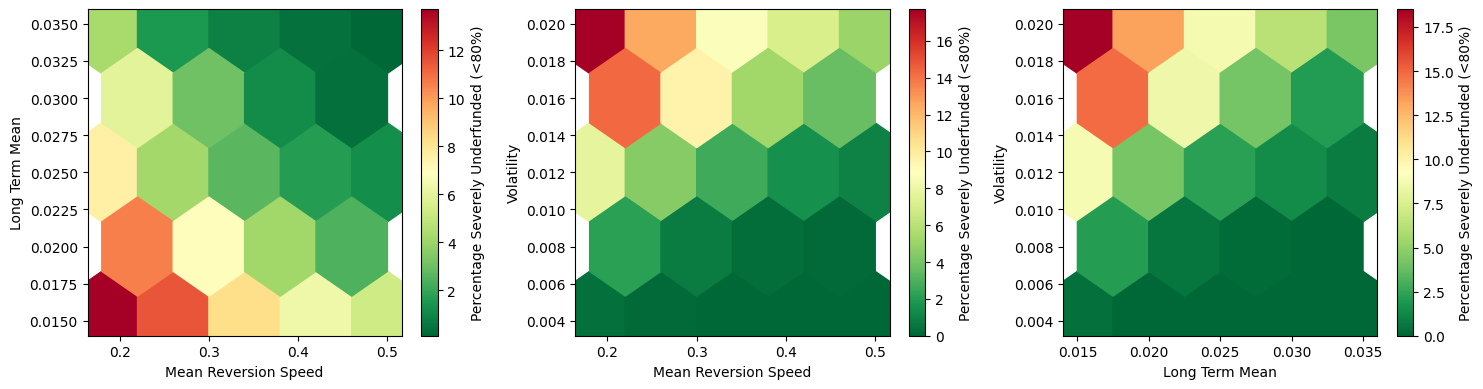

In [145]:
#plot = sa_mean.plot()
plot1 = sa_under.plot()
#plot2 = sa_md.plot()

In [138]:
styled_dict= sa_under.styled_dfs()

C:\Users\ezras_rv8t6h7\AppData\Local\Programs\Python\Python313\Lib\site-packages\sensitivity\df.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_or_series = df[[col1, col2, result_col]].groupby([col1, col2]).apply(agg_func)


KeyError: 'Percentage Severely Underfunded (<80%)'

In [ ]:
def plot_funding_ratio_fan_chart(funding_ratios_over_time, dt=1/12):
    """
    Fan chart showing funding ratio evolution with percentile bands
    funding_ratios_over_time: (n_paths, n_steps) array
    """
    n_paths, n_steps = funding_ratios_over_time.shape
    time_years = np.arange(n_steps) * dt
    
    # Calculate percentiles
    p10 = np.percentile(funding_ratios_over_time, 10, axis=0)
    p25 = np.percentile(funding_ratios_over_time, 25, axis=0)
    p50 = np.percentile(funding_ratios_over_time, 50, axis=0)
    p75 = np.percentile(funding_ratios_over_time, 75, axis=0)
    p90 = np.percentile(funding_ratios_over_time, 90, axis=0)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Fan chart
    ax.fill_between(time_years, p10, p90, alpha=0.2, color='steelblue', 
                    label='10th-90th percentile')
    ax.fill_between(time_years, p25, p75, alpha=0.4, color='steelblue', 
                    label='25th-75th percentile')
    ax.plot(time_years, p50, color='darkblue', linewidth=3, label='Median')
    
    # Reference lines
    ax.axhline(y=1.0, color='green', linestyle='--', linewidth=2, 
               label='Fully Funded (100%)')

    ax.set_xlabel('Time (Years)', fontsize=12)
    ax.set_ylabel('Funding Ratio', fontsize=12)
    ax.set_title('Pension Funding Ratio Projection - Vasicek Model\n1,000 Simulated Scenarios', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, 1.5])
    
    # Add annotation
    final_median = p50[-1]
    final_p10 = p10[-1]
    textstr = f'10-Year Results:\nMedian FR: {final_median:.2%}\n5th %ile: {final_p10:.2%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    return fig
vasicek_plot = plot_funding_ratio_fan_chart(vasicek_fr['funding_ratios_over_time'])